# Installing dependencies

In [1]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

# Imports

In [2]:
import os
import random

#Data
import numpy as np
import pandas as pd
import re
import json
import math

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import networkx as nx
from tqdm import tqdm

# Models
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
from openai import OpenAI
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import umap

#Metrics
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#Transformations
from sklearn.preprocessing import normalize
import networkx as nx
from itertools import combinations
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from collections import Counter
import ast

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-07-15 02:49:47.072625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752547787.255172      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752547787.310756      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data

def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""
    print("Cleaning text")
    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
def get_segments(text: str, max_tokens = 200) -> list[str]:
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    print("Doing semantic segmentation...")
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": text}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
def generate_embeddings(texts: list[str]):
    print("Generating embeddings for each segmentation")
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in texts:
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

In [7]:
def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

In [8]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

df = df.drop(columns=['Holy See (Vatican City State)'])
df = df.rename(columns={'Viet Nam': 'Vietnam',
                        'Brunei Darussalam': 'Brunei',
                        'Iran, Islamic Republic of': 'Iran',
                        "Lao People's Democratic Republic": 'Laos',
                        'Türkiye': 'Turkey',
                        'Syrian Arab Republic': 'Syria',
                        'Russian Federation': 'Russia',
                        'Palestine, State of': 'Palestine',
                        'Korea, Republic of': 'South Korea',
                        "Korea, Democratic People's Republic of": 'North Korea',
                        'Bolivia, Plurinational State of': 'Bolivia',
                        'Moldova, Republic of': 'Moldova',
                        'Tanzania, United Republic of': 'Tanzania',
                        'Micronesia, Federated States of':'Micronesia',
                        'Venezuela, Bolivarian Republic of': 'Venezuela',
                        'Cabo Verde':'Cape Verde',
                        'Timor-Leste': 'East Timor',
                        'Congo, The Democratic Republic of the': 'Democratic Republic of the Congo',
                        'Czechia': 'Czech Republic',
                        'Congo': 'Republic of the Congo'})

In [9]:
df = df.drop(columns=['Palestine'])
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
speech_data = []
for country in countries:
    speech_data.append(list(df[country]))

speech_data = np.array(speech_data)

# Combining speech embeddings and knowledge based embeddings

In [10]:
cl_speeches = pd.read_pickle("/kaggle/input/embedded-speeches/Make dataset (1).pkl")
cl_speeches = cl_speeches.drop(columns=['country1', 'country2', 'year'])
print(len(cl_speeches))
cl_speeches = cl_speeches.dropna()
print(len(cl_speeches))

20000
20000


In [11]:
cl_speeches['alignment_score'] = cl_speeches['alignment_score']**(np.log(0.5)/np.log(cl_speeches['alignment_score'].mean()))

<Axes: xlabel='alignment_score', ylabel='Count'>

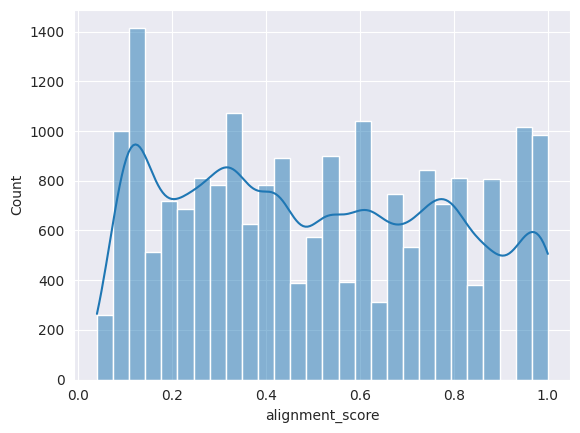

In [12]:
sns.histplot(cl_speeches, x='alignment_score', kde=True)

In [13]:
class EmbeddingPairDataset(Dataset):
    def __init__(self, cl_speeches):
        self.emb1 = cl_speeches["speech1"].tolist()
        self.emb2 = cl_speeches["speech2"].tolist()
        self.scores = cl_speeches["alignment_score"].astype(float).tolist()
        self.emb1 = [i.tolist() for i in self.emb1]
        self.emb2 = [i.tolist() for i in self.emb2]
        self.emb1 = torch.tensor(self.emb1, dtype=torch.float32)
        self.emb2 = torch.tensor(self.emb2, dtype=torch.float32)
        self.scores = torch.tensor(self.scores, dtype=torch.float32)

    def __len__(self):
        return len(self.scores)
    def __getitem__(self, idx):
        return self.emb1[idx], self.emb2[idx], self.scores[idx]

class ProjectionNet(nn.Module):
    def __init__(self, input_dim, proj_dim=512):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, proj_dim),
        )
    def forward(self, x):
        return F.normalize(self.proj(x), dim=-1)

def cosine_similarity_loss(x,y,target_sim):
    cos_sim = F.cosine_similarity(x,y)
    return F.mse_loss(cos_sim, target_sim)

dataset = EmbeddingPairDataset(cl_speeches)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = ProjectionNet(4096).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

------------------------------
           Training
------------------------------


Training epoch 1 | Batch: 100%|██████████| 625/625 [00:04<00:00, 140.28it/s]


Epoch: 001 | Loss: 0.06124


Training epoch 2 | Batch: 100%|██████████| 625/625 [00:03<00:00, 161.33it/s]


Epoch: 002 | Loss: 0.03294


Training epoch 3 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.90it/s]


Epoch: 003 | Loss: 0.02931


Training epoch 4 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.30it/s]


Epoch: 004 | Loss: 0.02946


Training epoch 5 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.03it/s]


Epoch: 005 | Loss: 0.02437


Training epoch 6 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.27it/s]


Epoch: 006 | Loss: 0.02370


Training epoch 7 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.16it/s]


Epoch: 007 | Loss: 0.02154


Training epoch 8 | Batch: 100%|██████████| 625/625 [00:03<00:00, 161.68it/s]


Epoch: 008 | Loss: 0.01840


Training epoch 9 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.63it/s]


Epoch: 009 | Loss: 0.01818


Training epoch 10 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.23it/s]


Epoch: 010 | Loss: 0.01692


Training epoch 11 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.46it/s]


Epoch: 011 | Loss: 0.01530


Training epoch 12 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.13it/s]


Epoch: 012 | Loss: 0.01518


Training epoch 13 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.06it/s]


Epoch: 013 | Loss: 0.01538


Training epoch 14 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.87it/s]


Epoch: 014 | Loss: 0.01477


Training epoch 15 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.59it/s]


Epoch: 015 | Loss: 0.01477


Training epoch 16 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.74it/s]


Epoch: 016 | Loss: 0.01466


Training epoch 17 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.34it/s]


Epoch: 017 | Loss: 0.01481


Training epoch 18 | Batch: 100%|██████████| 625/625 [00:03<00:00, 156.70it/s]


Epoch: 018 | Loss: 0.01432


Training epoch 19 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.03it/s]


Epoch: 019 | Loss: 0.01388


Training epoch 20 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.36it/s]


Epoch: 020 | Loss: 0.01374


Training epoch 21 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.52it/s]


Epoch: 021 | Loss: 0.01314


Training epoch 22 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.09it/s]


Epoch: 022 | Loss: 0.01296


Training epoch 23 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.80it/s]


Epoch: 023 | Loss: 0.01302


Training epoch 24 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.52it/s]


Epoch: 024 | Loss: 0.01321


Training epoch 25 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.95it/s]


Epoch: 025 | Loss: 0.01261


Training epoch 26 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.10it/s]


Epoch: 026 | Loss: 0.01222


Training epoch 27 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.35it/s]


Epoch: 027 | Loss: 0.01221


Training epoch 28 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.84it/s]


Epoch: 028 | Loss: 0.01135


Training epoch 29 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.62it/s]


Epoch: 029 | Loss: 0.01075


Training epoch 30 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.12it/s]


Epoch: 030 | Loss: 0.01064


Training epoch 31 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.49it/s]


Epoch: 031 | Loss: 0.01036


Training epoch 32 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.47it/s]


Epoch: 032 | Loss: 0.01029


Training epoch 33 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.60it/s]


Epoch: 033 | Loss: 0.01008


Training epoch 34 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.75it/s]


Epoch: 034 | Loss: 0.00936


Training epoch 35 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.17it/s]


Epoch: 035 | Loss: 0.01015


Training epoch 36 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.99it/s]


Epoch: 036 | Loss: 0.00937


Training epoch 37 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.23it/s]


Epoch: 037 | Loss: 0.00911


Training epoch 38 | Batch: 100%|██████████| 625/625 [00:03<00:00, 167.29it/s]


Epoch: 038 | Loss: 0.00847


Training epoch 39 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.55it/s]


Epoch: 039 | Loss: 0.00854


Training epoch 40 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.27it/s]


Epoch: 040 | Loss: 0.00892


Training epoch 41 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.44it/s]


Epoch: 041 | Loss: 0.00864


Training epoch 42 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.42it/s]


Epoch: 042 | Loss: 0.00854


Training epoch 43 | Batch: 100%|██████████| 625/625 [00:03<00:00, 161.01it/s]


Epoch: 043 | Loss: 0.00868


Training epoch 44 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.06it/s]


Epoch: 044 | Loss: 0.00873


Training epoch 45 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.86it/s]


Epoch: 045 | Loss: 0.00826


Training epoch 46 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.28it/s]


Epoch: 046 | Loss: 0.00833


Training epoch 47 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.26it/s]


Epoch: 047 | Loss: 0.00794


Training epoch 48 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.98it/s]


Epoch: 048 | Loss: 0.00743


Training epoch 49 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.44it/s]


Epoch: 049 | Loss: 0.00779


Training epoch 50 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.70it/s]


Epoch: 050 | Loss: 0.00792


Training epoch 51 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.42it/s]


Epoch: 051 | Loss: 0.00875


Training epoch 52 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.09it/s]


Epoch: 052 | Loss: 0.00833


Training epoch 53 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.60it/s]


Epoch: 053 | Loss: 0.00815


Training epoch 54 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.69it/s]


Epoch: 054 | Loss: 0.00851


Training epoch 55 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.51it/s]


Epoch: 055 | Loss: 0.00791


Training epoch 56 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.19it/s]


Epoch: 056 | Loss: 0.00767


Training epoch 57 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.37it/s]


Epoch: 057 | Loss: 0.00743


Training epoch 58 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.89it/s]


Epoch: 058 | Loss: 0.00729


Training epoch 59 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.24it/s]


Epoch: 059 | Loss: 0.00716


Training epoch 60 | Batch: 100%|██████████| 625/625 [00:03<00:00, 162.67it/s]


Epoch: 060 | Loss: 0.00750


Training epoch 61 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.92it/s]


Epoch: 061 | Loss: 0.00743


Training epoch 62 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.58it/s]


Epoch: 062 | Loss: 0.00774


Training epoch 63 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.65it/s]


Epoch: 063 | Loss: 0.00798


Training epoch 64 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.94it/s]


Epoch: 064 | Loss: 0.00715


Training epoch 65 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.16it/s]


Epoch: 065 | Loss: 0.00699


Training epoch 66 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.15it/s]


Epoch: 066 | Loss: 0.00717


Training epoch 67 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.88it/s]


Epoch: 067 | Loss: 0.00692


Training epoch 68 | Batch: 100%|██████████| 625/625 [00:03<00:00, 159.19it/s]


Epoch: 068 | Loss: 0.00720


Training epoch 69 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.73it/s]


Epoch: 069 | Loss: 0.00694


Training epoch 70 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.00it/s]


Epoch: 070 | Loss: 0.00720


Training epoch 71 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.74it/s]


Epoch: 071 | Loss: 0.00679


Training epoch 72 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.20it/s]


Epoch: 072 | Loss: 0.00661


Training epoch 73 | Batch: 100%|██████████| 625/625 [00:03<00:00, 166.34it/s]


Epoch: 073 | Loss: 0.00710


Training epoch 74 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.29it/s]


Epoch: 074 | Loss: 0.00713


Training epoch 75 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.54it/s]


Epoch: 075 | Loss: 0.00652


Training epoch 76 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.61it/s]


Epoch: 076 | Loss: 0.00685


Training epoch 77 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.82it/s]


Epoch: 077 | Loss: 0.00642


Training epoch 78 | Batch: 100%|██████████| 625/625 [00:03<00:00, 164.99it/s]


Epoch: 078 | Loss: 0.00625


Training epoch 79 | Batch: 100%|██████████| 625/625 [00:03<00:00, 163.68it/s]


Epoch: 079 | Loss: 0.00682


Training epoch 80 | Batch: 100%|██████████| 625/625 [00:03<00:00, 165.15it/s]


Epoch: 080 | Loss: 0.00731
------------------------------
           Results
------------------------------
Final Loss: 0.0062
Original standard deviation: 0.2815
Percent improvement: 4405.4920%


Text(0.5, 1.0, 'Loss History')

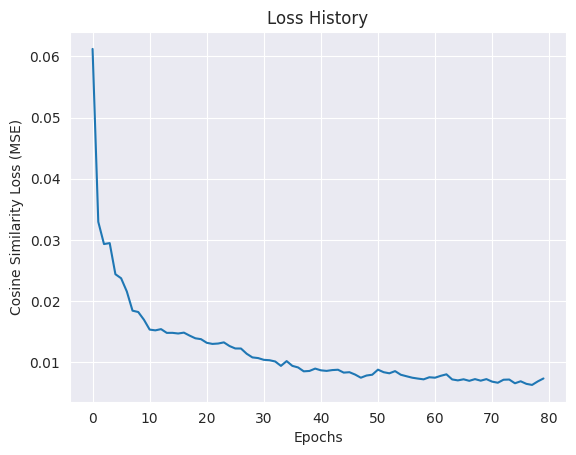

In [14]:
print("-"*30 + "\n" + " "*11 +"Training\n" + "-"*30)

best_loss = float('inf')
patience = 10
wait = 0
history = []

for epoch in range(80):
    total_loss = 0
    for a, b, score in tqdm(dataloader, desc=f'Training epoch {epoch+1} | Batch'):
        a = a.to(device)
        b = b.to(device)
        score = score.to(device)

        proj_a = model(a)
        proj_b = model(b)

        loss = cosine_similarity_loss(proj_a, proj_b, score)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(score)

    epoch_loss = total_loss / len(dataset)
    print(f"Epoch: {str(epoch + 1).zfill(3)} | Loss: {epoch_loss:.5f}")
    history.append(epoch_loss)

    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

scores = dataset.scores.cpu().numpy()

print("-"*30 + "\n" + " "*11 +"Results\n" + "-"*30)
print(f"Final Loss: {best_loss:.4f}")
print(f"Original standard deviation: {np.std(scores):.4f}")
print(f"Percent improvement: {(np.std(scores)/best_loss - 1)*100:.4f}%")

sns.lineplot(x=range(len(history)), y=history)
plt.xlabel("Epochs")
plt.ylabel("Cosine Similarity Loss (MSE)")
plt.title("Loss History")

In [15]:
model.eval()

with torch.no_grad():
    speech_emb = torch.tensor(speech_data).float().to(device) 
    fused_output = model(speech_emb)
    transformed_speech = fused_output.squeeze(0)

In [16]:
combined_embedding = torch.reshape(torch.tensor(transformed_speech), (512, 192))

np_array = combined_embedding.detach().cpu().numpy()
final_country_embeddings = pd.DataFrame(np_array, columns=countries)

In [17]:
def compare_countries(country1, country2):
    cs = cosine_similarity(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )
    return cs

# Visualizing and testing

In [18]:
umap_model = umap.UMAP(n_components=5, random_state=42)
speech_umap = umap_model.fit_transform(final_country_embeddings)
or_speech_umap = umap_model.fit_transform(speech_data)

from scipy.spatial.distance import pdist, squareform

def get_distance_matrix(umap_embeddings, countries, sample_size=5):
    idx = sorted(random.sample(range(len(countries)), sample_size))
    selected = umap_embeddings[idx]
    dist_matrix = squareform(pdist(selected, metric='euclidean'))
    selected_countries = [countries[i] for i in idx]
    df = pd.DataFrame(dist_matrix, index=selected_countries, columns=selected_countries)
    return df

Text(0.5, 1.0, 'UMAP Distance Between Country Policy Embeddings')

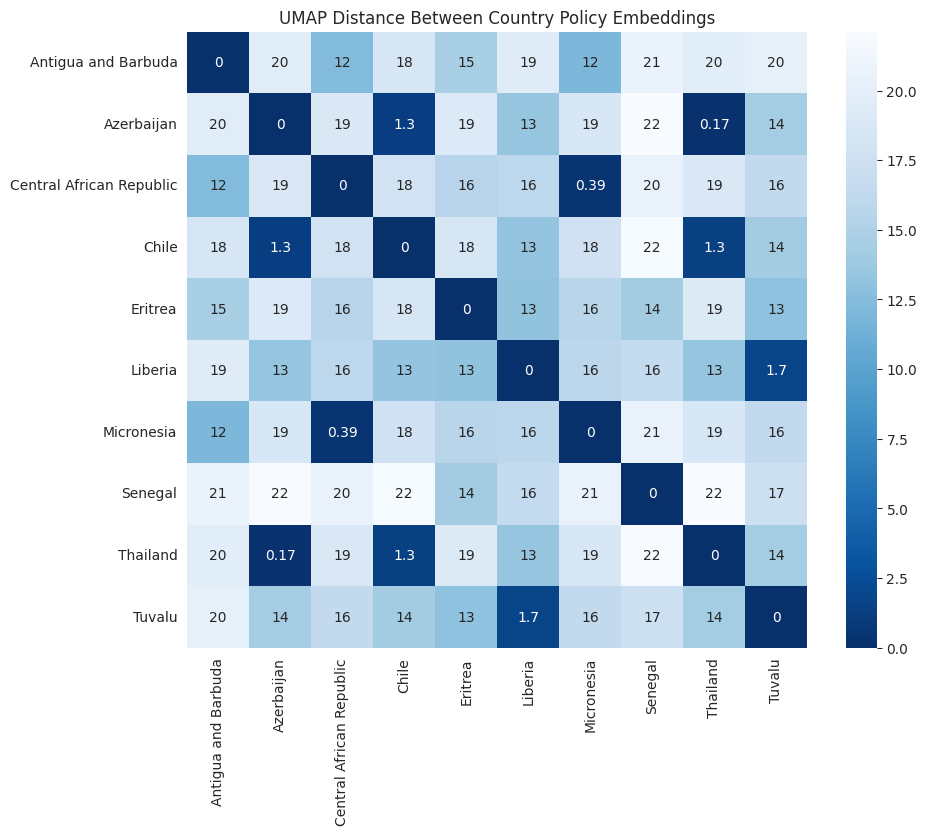

In [19]:
plt.figure(figsize=(10,8))

speech_umap_df = get_distance_matrix(speech_umap, countries, 10)
or_speech_umap_df = get_distance_matrix(or_speech_umap, countries, 10)

sns.heatmap(speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance Between Country Policy Embeddings')

Text(0.5, 1.0, 'UMAP Distance in Original Speech Embeddings')

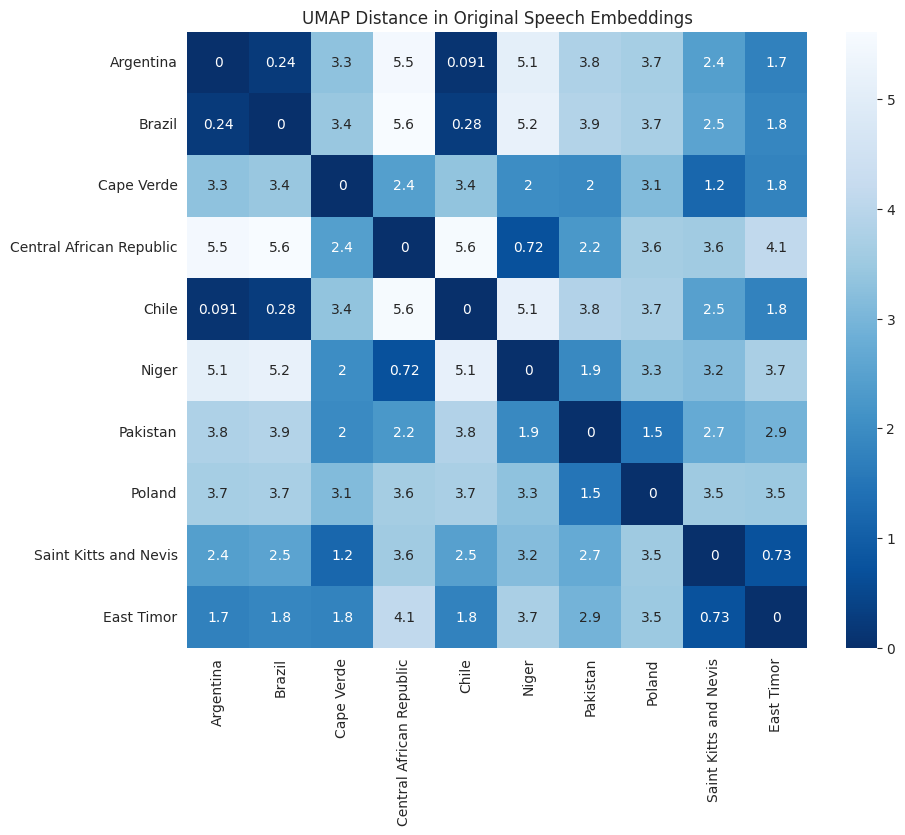

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(or_speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance in Original Speech Embeddings')

In [21]:
def get_umap_map(umap):
    distances = []
    for i in range(len(countries)):
        dists = [j**2 for j in umap[i]]
        dists = math.sqrt(sum(dists))
        distances.append(dists)
    
    world_map = pd.DataFrame({'country': countries, 'value': distances})
    fig = px.choropleth(world_map,
                    locations="country",         # Can also use 'iso_alpha' (ISO-3 codes)
                    locationmode="country names",# or "ISO-3"
                    color="value",               # The numeric column to color by
                    color_continuous_scale="Cividis",  # Or 'Plasma', 'Cividis', etc.
                    title="World Map by Euclidian Distance of graph")
    
    fig.show()

get_umap_map(speech_umap)

In [22]:
full_umap = get_distance_matrix(or_speech_umap, countries, 190)

In [23]:
original_country_embeddings = pd.DataFrame(speech_data).T
original_country_embeddings.columns = final_country_embeddings.columns

In [24]:
umap_projector = umap.UMAP(n_components=2, random_state=42)

def generate_country_similarity(speech: str, place: str, df):
    clean_speech = clean_text(speech)
    segments = get_segments(clean_speech)
    segment_embeddings = np.array(generate_embeddings(segments))
    av_vec = np.mean(segment_embeddings, axis=0)
    av_vec = np.expand_dims(av_vec, axis=0)  # shape: (1, 4096)

    model.eval()
    with torch.no_grad():
        speech_emb = torch.tensor(av_vec).float().to(device)
        
        fused_output = model(speech_emb)
        fused_speech_vec = fused_output.squeeze(0).cpu().numpy()

    country_names = list(final_country_embeddings.columns)
    country_matrix = np.stack([final_country_embeddings[c] for c in country_names])

    sims = cosine_similarity([fused_speech_vec], country_matrix)[0]
    sorted_data = sorted(zip(sims, country_names), key=lambda x: -x[0])
    print("\n\nPolicy Alignment Scores (Cosine Similarity: closer to 1 = better alignment)\n")
    for sim, country in sorted_data:
        if country == place:
            print(f'\n\n-----{country}------\n\n')
            print(f"{sim:.6f} — {country}")
            if sim > 0.85:
                print("You did a great job in policy alignment!!!")
            print("\n\n")
        else:
            print(f"{sim:.6f} — {country}")

    country_sim_list = [(country, sim) for sim, country in sorted_data]
    countries, values = zip(*country_sim_list)
    sim_df = pd.DataFrame({'country': countries, 'value': values})
    all_vectors = np.vstack([fused_speech_vec, country_matrix])
    all_umap = umap_projector.fit_transform(all_vectors)
    speech_umap = all_umap[0]
    country_umap = all_umap[1:]
    fig = px.choropleth(sim_df,
                        locations="country",
                        locationmode="country names",
                        color="value",
                        color_continuous_scale="Viridis",
                        projection="natural earth",
                        title="World Map: Policy Alignment via Cosine Similarity")

    fig.show()

In [25]:
def get_country_stats(country: str, num: int):
    distances = full_umap[country].copy()
    closest_countries = distances[distances > 0].nsmallest(num)
    print(f"3 closest countries to {country}: (UMAP Euclidian Distance)")
    print(', '.join(closest_countries.keys()))
    print("\n")
    print(f"Socioeconomic statistics of {country} as of 2023")
    country_data = pd.DataFrame(socioeconomic[socioeconomic['countries']==country]).drop(columns=['countries']).rename(columns={'Density\n(P/Km2)': 'Density (P/Km2)'})
    print(''.join(f"   - {column}: {country_data.iloc[0][column]}\n" for column in country_data.columns))

In [26]:
MUN_speeches = pd.read_csv("/kaggle/input/mun-speech-dataset/MUN Speech Testing.csv")
index = random.randint(0, len(MUN_speeches)-1)
print(f"Policy similarities of speech:\n\n{MUN_speeches.loc[index]['Speech']} \n\nFrom delegate of nation: {MUN_speeches.loc[index]['Country']}\n\n")
print(f"\nBasic information about {MUN_speeches.loc[index]['Country']}:\n")
print(f"{MUN_speeches.loc[index]['Country']} is part of the following organizations")
#print("".join(f"   - {organization}\n" for organization in get_organizations(MUN_speeches.loc[index]['Country'])))

generate_country_similarity(MUN_speeches.loc[index]['Speech'], MUN_speeches.loc[index]['Country'], df)

Policy similarities of speech:

The delegate of Brazil stands before this committee with an unwavering commitment to advancing women's rights, particularly for those in rural areas who exist onw the fringes of economic progress. Women are the backbone of rural economies, yet they continue to face systemic barriers that limit their access to education, financial independence, and economic security. In Brazil, over 18% of our population lives in rural areas, with one-third of rural women being functionally illiterate. This harsh reality confines them to cycles of poverty and dependence, limiting their ability to engage in the workforce. Much more alarmingly, economic vulnerability exposes them to gender-based violence, with rural women being disproportionately affected by femicide and exploitation. Education is the key to addressing and dismantling these inequalities. Brazil advocates for targeted policies that enhance rural education, vocational training, and digital literacy programs. 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Policy Alignment Scores (Cosine Similarity: closer to 1 = better alignment)

0.101889 — Colombia
0.088250 — South Korea
0.088243 — Saint Lucia
0.082988 — Pakistan
0.081977 — North Macedonia
0.077164 — Qatar
0.075282 — Guinea
0.073663 — Vanuatu
0.073146 — Nepal
0.071790 — Saint Kitts and Nevis
0.070524 — Honduras
0.069992 — Netherlands
0.065403 — Guatemala
0.061660 — Finland
0.059391 — Croatia
0.056282 — Vietnam
0.055705 — Ireland
0.055516 — Republic of the Congo
0.053173 — Belgium
0.050872 — Burundi
0.049765 — Myanmar
0.048649 — Tonga
0.047843 — Seychelles
0.046952 — Slovenia
0.046411 — Jamaica
0.045648 — Sweden
0.042351 — Nigeria
0.038726 — Australia
0.035590 — Madagascar
0.032548 — Iceland
0.030726 — Burkina Faso
0.029299 — Suriname
0.028813 — Rwanda
0.028650 — Kiribati
0.027191 — Ethiopia
0.026950 — Spain
0.025642 — Mozambique
0.025164 — Eswatini
0.024502 — Montenegro
0.024311 — Kazakhstan
0.023475 — Austria
0.022189 — Romania
0.022013 — Zimbabwe
0.021818 — Venezuela
0.021226 — Ba